# PRMT-1862 Attachment Sizes for NME / GPC Team

### Context

The NME(New Market Entrant) need to understand the size of the attachments being transferred via GP2GP, in order to inform their decisions for GP Connect and reduce the need to chunk attachments.

There is some effort required to de-duplicate the underlying data. This is explored in notebook `10-PRMT-1528` and `PRMT-1724`. The date range used was 1st January 2021 00:00:00 to 31 March 2021 24:00:00.

### Requirements

In order to replicate this notebook, perform the following steps:

1. Log into Splunk and run the following query for:
- 01/01/2021 00:00:00:00 to 31/01/2021 24:00:00 (using Date Range) and export the result as a CSV, gzip and name `1-2021-attachment-metadata.csv.gz`
- 01/02/2021 00:00:00:00 to 28/02/2021 24:00:00 (using Date Range) and export the result as a CSV, gzip and name `2-2021-attachment-metadata.csv.gz`
- 01/03/2021 00:00:00:00 to 31/03/2021 24:00:00 (using Date Range) and export the result as a CSV, gzip and name `3-2021-attachment-metadata.csv.gz`

Splunk Query for all attachment metadata:
```
index="spine2vfmmonitor" logReference=MPS0208
| table _time, attachmentID, conversationID, FromSystem, ToSystem, attachmentType, Compressed, ContentType, LargeAttachment, Length, OriginalBase64, internalID

```

2. Run the following Splunk query for the following month ranges:
- 01/01/2021 00:00:00:00 to 31/01/2021 24:00:00 (using Date Range) and export result as `1-2021-gp2gp-messages.csv`
- 01/02/2021 00:00:00:00 to 28/02/2021 24:00:00 (using Date Range) and expoert result as `2-2021-gp2gp-messages.csv`
- 01/03/2021 00:00:00:00 to 31/03/2021 24:00:00 (using Date Range) and export result as `3-2021-gp2gp-messages.csv`

Splunk query for GP2GP messages:
```
index="spine2vfmmonitor" service="gp2gp" logReference="MPS0053c"
| table _time, conversationID, internalID, interactionID
```

3. Run the following Athena queries:
- Listed in `athena/create_deduplicated_attachment_metadata.sql` - that will generate a parquet output to the location `s3://prm-gp2gp-data-sandbox-dev/attachment-insights/gp2gp_attachments_q1_2021_v3/gp2gp_attachments_q1_2021.parquet`
- Listed in `athena/create_gp2gp_ehr_attachment_summary.sql` that will generate a parquet output to the location `s3://prm-gp2gp-data-sandbox-dev/attachment-insights/gp2gp_ehr_attachment_summary_q1_2021/`

In [39]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [40]:
attachment_metadata = pd.read_parquet("s3://prm-gp2gp-data-sandbox-dev/attachment-insights/gp2gp_attachments_q1_2021_v4/")

In [41]:
start_time = attachment_metadata['time'].min()
end_time = attachment_metadata['time'].max()

start_date = start_time.date()
end_date = end_time.date()

print(f"Min time of dataset: {start_time}")
print(f"Max time of dataset: {end_time}")

Min time of dataset: 2021-01-01 06:12:24.691000
Max time of dataset: 2021-03-31 22:20:53.411000


In [42]:
transfers_with_attachment_count = pd.read_parquet("s3://prm-gp2gp-data-sandbox-dev/attachment-insights/gp2gp_ehr_attachment_summary_q1_2021")

In [43]:
attachments = attachment_metadata.copy()

## Attachment counts

In [44]:
print("Total transfers: ", len(transfers_with_attachment_count))
print("Transfers with attachments: ", (transfers_with_attachment_count["attachment_count"] != 0).sum())
print("Transfers without attachments: ", (transfers_with_attachment_count["attachment_count"] == 0).sum())
total_attachments_count = transfers_with_attachment_count["attachment_count"].sum()
print("Total attachments:", total_attachments_count)

Total transfers:  757634
Transfers with attachments:  374654
Transfers without attachments:  382980
Total attachments: 23955178


In [45]:
print("Number of attachments per transfer")
transfers_with_attachment_count["attachment_count"].describe()

Number of attachments per transfer


count   757634.00
mean        31.62
std         54.81
min          0.00
25%          0.00
50%          0.00
75%         45.00
max       2658.00
Name: attachment_count, dtype: float64

### Thresholds (Mb)

In [46]:
attachments["length_mb"] = attachments["length"] / (1024.0*1024.0)

In [47]:
def greater_than_threshold_count(row):
    greater_than_limit = attachments["length_mb"] > row["threshold_mb"]
    return len(attachments[greater_than_limit])

In [48]:
def calculate_percentage(subset, total):
    return round((subset/total) * 100, 5)

def greater_than_threshold_percentage(row):
    return f'{calculate_percentage(row["transfers_above_threshold"], total_attachments_count)}%'

In [49]:
thresholds = pd.DataFrame({'threshold_mb': [5, 20, 100]})
thresholds["transfers_above_threshold"] = thresholds.apply(greater_than_threshold_count, axis=1)
thresholds["transfers_above_threshold_percent"] = thresholds.apply(greater_than_threshold_percentage, axis=1)
thresholds

,threshold_mb,transfers_above_threshold,transfers_above_threshold_percent
0,5,233793,0.97596%
1,20,35086,0.14647%
2,100,750,0.00313%


In [50]:
greater_than_100 = attachments["length_mb"] > 100
greater_than_20 = attachments["length_mb"] > 20
greater_than_5 = attachments["length_mb"] > 5

In [51]:
print("Stats on length (Mb) of attachments")
attachments["length_mb"].describe()

Stats on length (Mb) of attachments


count   23954997.00
mean           0.31
std            1.92
min            0.00
25%            0.02
50%            0.04
75%            0.12
max          676.58
Name: length_mb, dtype: float64

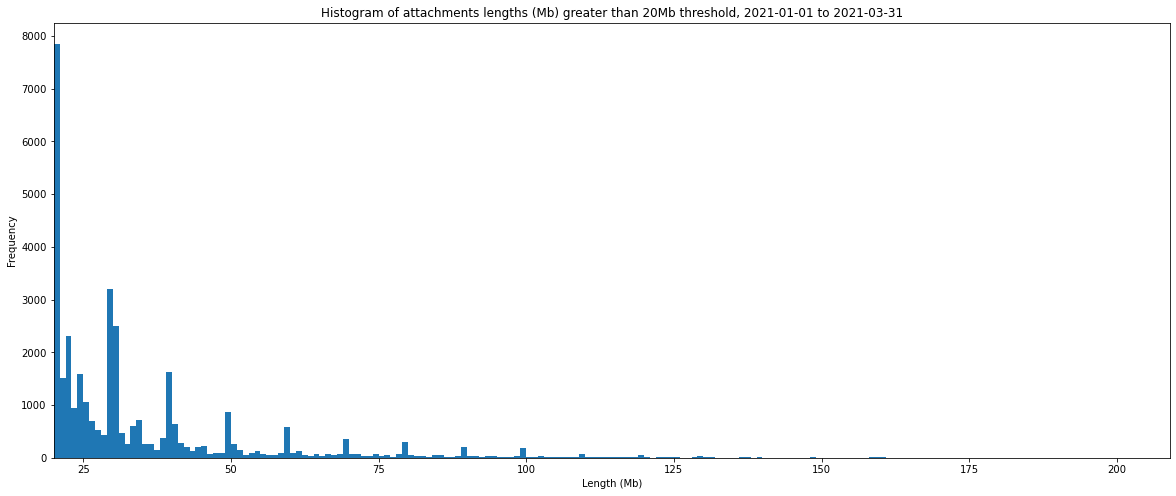

In [52]:
attachments_length_mb_greater_than_20_hist = attachments[greater_than_20]["length_mb"].plot.hist(title=f"Histogram of attachments lengths (Mb) greater than 20Mb threshold, {start_date} to {end_date}", bins=range(200), figsize=(20,8))
attachments_length_mb_greater_than_20_hist.set_xlim(20)
attachments_length_mb_greater_than_20_hist.set(xlabel="Length (Mb)", ylabel="Frequency")
attachments_length_mb_greater_than_20_hist.ticklabel_format(style='plain', axis='y')

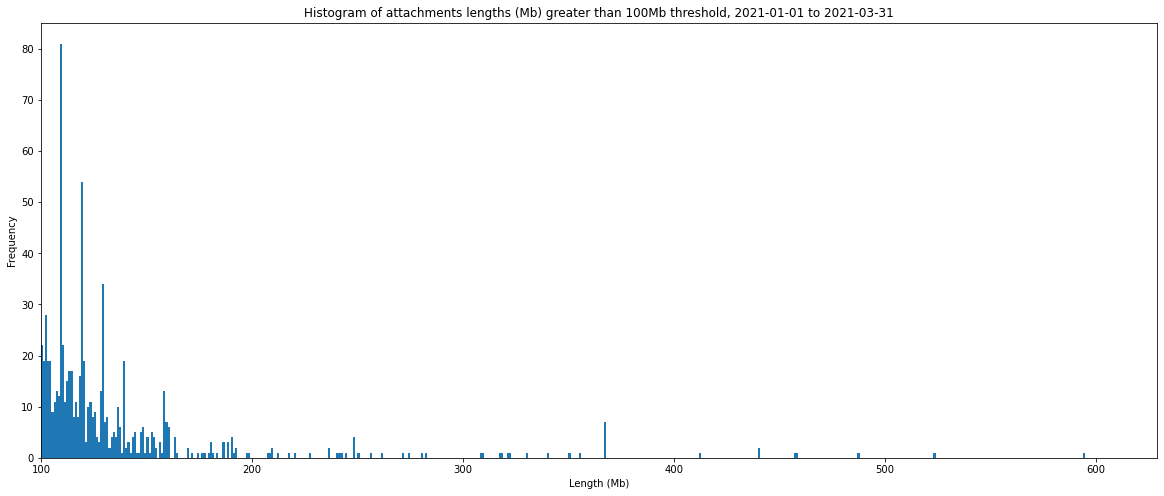

In [53]:
attachments_length_mb_greater_than_100_hist = attachments[greater_than_100]["length_mb"].plot.hist(title=f"Histogram of attachments lengths (Mb) greater than 100Mb threshold, {start_date} to {end_date}", bins=range(600), figsize=(20,8))
attachments_length_mb_greater_than_100_hist.set_xlim(100)
attachments_length_mb_greater_than_100_hist.set(xlabel="Length (Mb)", ylabel="Frequency")
attachments_length_mb_greater_than_100_hist.ticklabel_format(style='plain', axis='y')

## Attachment content types

In [54]:
attachments.groupby("content_type").describe()

length                                  \
                               count       mean        std       min   
content_type                                                           
NotProvided                    51.00  577116.71  366739.71  10074.00   
Unknown                         0.00        nan        nan       nan   
application/msword        2241031.00  121805.55  351793.35      4.00   
application/octet-stream   473929.00   66257.08  933949.33      8.00   
application/pdf           1245073.00  406538.98 2709089.48     24.00   
application/xml            321209.00   18594.23   77961.57     96.00   
audio/basic                    63.00  553638.06 1055157.95  68458.00   
audio/mpeg                     81.00 2658658.42 1456030.31 424704.00   
image/gif                     579.00  272088.22  944583.48    172.00   
image/jpeg                 491139.00  608633.06  834994.01   1196.00   
image/png                 1109001.00  138782.53  879767.41    196.00   
image/tiff               11751118.00  531376.04 2689524.22     16.00   
text/html                  376399.00    6198.20   21607.53      8.00   
text/plain                1323713.00     480.72    3110.22      4.00   
text/rtf                  4578229.00   61694.41  208895.42      4.00   
text/xml                    43382.00  577510.86  490539.86    114.00   

                                                                        \
                                25%        50%        75%          max   
content_type                                                             
NotProvided               356198.00  368450.00  888357.00   1351678.00   
Unknown                         nan        nan        nan          nan   
application/msword          9428.00   34332.00   97876.00  74188152.00   
application/octet-stream    3804.00    4972.00   24552.00 165721124.00   
application/pdf            59540.00  113484.00  350764.00 709447892.00   
application/xml             3156.00    4280.00    9464.00  10034204.00   
audio/basic               164963.00  238076.00  305422.00   5684476.00   
audio/mpeg               1661182.00 2310928.00 3390096.00   6602200.00   
image/gif                  70230.00  123532.00  269642.00  17565628.00   
image/jpeg                219622.00  361722.00  754468.00  48771144.00   
image/png                  30160.00   43474.00   89942.00  69543456.00   
image/tiff                 37268.00   64216.00  179180.00 480108124.00   
text/html                   1308.00    2100.00    5446.00   3149298.00   
text/plain                   224.00     224.00     232.00   1603248.00   
text/rtf                    7820.00   14072.00   38822.00  40347132.00   
text/xml                   44525.00  625844.00  852367.00   5675020.00   

                           length_mb                                       
                               count mean  std  min  25%  50%  75%    max  
content_type                                                               
NotProvided                    51.00 0.55 0.35 0.01 0.34 0.35 0.85   1.29  
Unknown                         0.00  nan  nan  nan  nan  nan  nan    nan  
application/msword        2241031.00 0.12 0.34 0.00 0.01 0.03 0.09  70.75  
application/octet-stream   473929.00 0.06 0.89 0.00 0.00 0.00 0.02 158.04  
application/pdf           1245073.00 0.39 2.58 0.00 0.06 0.11 0.33 676.58  
application/xml            321209.00 0.02 0.07 0.00 0.00 0.00 0.01   9.57  
audio/basic                    63.00 0.53 1.01 0.07 0.16 0.23 0.29   5.42  
audio/mpeg                     81.00 2.54 1.39 0.41 1.58 2.20 3.23   6.30  
image/gif                     579.00 0.26 0.90 0.00 0.07 0.12 0.26  16.75  
image/jpeg                 491139.00 0.58 0.80 0.00 0.21 0.34 0.72  46.51  
image/png                 1109001.00 0.13 0.84 0.00 0.03 0.04 0.09  66.32  
image/tiff               11751118.00 0.51 2.56 0.00 0.04 0.06 0.17 457.87  
text/html                  376399.00 0.01 0.02 0.00 0.00 0.00 0.01   3.00  
text/plain                1323713.00 0

In [55]:
attachments[greater_than_20].groupby("content_type").describe()

length                                      \
                            count        mean         std         min   
content_type                                                            
application/msword          40.00 32164549.30 11993364.61 21021296.00   
application/octet-stream    73.00 47055120.55 48796021.65 21086080.00   
application/pdf           1126.00 53321073.04 65074586.86 20973672.00   
image/jpeg                   5.00 34755874.40 10594138.35 21330692.00   
image/png                  405.00 24158816.03  4175620.56 20979832.00   
image/tiff               33424.00 36675784.43 21943286.50 20971526.00   
text/rtf                    13.00 27188302.15  5630408.63 22220292.00   

                                                                           \
                                 25%         50%         75%          max   
content_type                                                                
application/msword       23645994.00 28724253.00 37536813.00  74188152.00   
application/octet-stream 23207532.00 25542672.00 34641260.00 165721124.00   
application/pdf          25013719.00 32587522.00 49964783.00 709447892.00   
image/jpeg               27623104.00 38027216.00 38027216.00  48771144.00   
image/png                21826820.00 22972160.00 24844888.00  69543456.00   
image/tiff               22634260.00 31078332.00 41697932.00 480108124.00   
text/rtf                 23485708.00 24701840.00 29306660.00  40347132.00   

                         length_mb                                             
                             count  mean   std   min   25%   50%   75%    max  
content_type                                                                   
application/msword           40.00 30.67 11.44 20.05 22.55 27.39 35.80  70.75  
application/octet-stream     73.00 44.88 46.54 20.11 22.13 24.36 33.04 158.04  
application/pdf            1126.00 50.85 62.06 20.00 23.85 31.08 47.65 676.58  
image/jpeg                    5.00 33.15 10.10 20.34 26.34 36.27 36.27  46.51  
image/png                   405.00 23.04  3.98 20.01 20.82 21.91 23.69  66.32  
image/tiff                33424.00 34.98 20.93 20.00 21.59 29.64 39.77 457.87  
text/rtf                     13.00 25.93  5.37 21.19 22.40 23.56 27.95  38.48

In [56]:
attachments[greater_than_100].groupby("content_type").describe()

length                                         \
                          count         mean          std          min   
content_type                                                             
application/octet-stream  11.00 160327229.09  17889525.57 106388280.00   
application/pdf          106.00 211164325.58 121464191.70 105434516.00   
image/tiff               633.00 131153293.17  35642109.12 104866892.00   

                                                                              \
                                  25%          50%          75%          max   
content_type                                                                   
application/octet-stream 165721124.00 165721124.00 165721124.00 165721124.00   
application/pdf          131340020.00 154460944.00 256126563.00 709447892.00   
image/tiff               114669292.00 123705356.00 135589648.00 480108124.00   

                         length_mb                                            \
                             count   mean    std    min    25%    50%    75%   
content_type                                                                   
application/octet-stream     11.00 152.90  17.06 101.46 158.04 158.04 158.04   
application/pdf             106.00 201.38 115.84 100.55 125.26 147.31 244.26   
image/tiff                  633.00 125.08  33.99 100.01 109.36 117.97 129.31   

                                 
                            max  
content_type                     
application/octet-stream 158.04  
application/pdf          676.58  
image/tiff               457.87

## Attachment compression

In [57]:
attachments.groupby("compressed").describe()

length                                                         \
                 count      mean        std   min      25%      50%       75%   
compressed                                                                      
False      15905721.00 377179.94 2238154.98  4.00 30680.00 55826.00 145928.00   
True        8049276.00 226753.67 1482297.82 32.00  5552.00 15216.00  63308.00   

                          length_mb                                       
                    max       count mean  std  min  25%  50%  75%    max  
compressed                                                                
False      480108124.00 15905721.00 0.36 2.13 0.00 0.03 0.05 0.14 457.87  
True       709447892.00  8049276.00 0.22 1.41 0.00 0.01 0.01 0.06 676.58

In [58]:
ratios = {
  "application/pdf": 0.88,
  "image/tiff": 0.78,
  "image/png": 0.99,
  "image/jpg": 0.82,
  "image/gif": 1.0,
  "text/html": 0.37,
  "text/plain": 0.37,
  "text/xml": 0.37,
  "text/rtf": 0.62,
  "application/msword": 0.62,
  "application/octet-stream": 1.0,
  "audio/basic": 0.7,
  "audio/mpeg": 0.9,
}

def calculate_compressed_size(row):
    if row["compressed"]:
        return row["length"]
    else:
        ratio = ratios.get(row["content_type"], 1.0)
        return row["length"] * ratio

In [59]:
attachments["compressed_size"] = attachments.apply(calculate_compressed_size, axis=1)

In [60]:
#is_not_compressed = ~attachments["compressed"]
#attachments["compressed_size_2"] = attachments["length"]
#attachments[] = attachments["length"]

In [61]:
attachments["compressed_size_mb"] = attachments["compressed_size"] / (1024.0*1024.0)

In [62]:
attachments[["compressed_size_mb"]].describe()

,compressed_size_mb
count,23954997.00
mean,0.26
std,1.59
min,0.00
25%,0.01
50%,0.03
75%,0.09
max,676.58


In [138]:
def count_attachments_over_compressed_threshold(row):
    greater_than_threshold = attachments["compressed_size_mb"] > row["threshold_mb"]
    return len(attachments[greater_than_threshold]);

def calculate_attachments_over_compressed_threshold_percent(row):
    return f'{calculate_percentage(row["attachments_over_compressed_threshold"], total_attachments_count)}%'

compressed_thresholds = pd.DataFrame({"threshold_mb": [5, 20, 100]})

compressed_thresholds["attachments_over_compressed_threshold"] = compressed_thresholds.apply(count_attachments_over_compressed_threshold, axis=1)
compressed_thresholds["attachments_over_compressed_threshold_percent"] = compressed_thresholds.apply(calculate_attachments_over_compressed_threshold_percent, axis=1)
compressed_thresholds

,threshold_mb,attachments_over_compressed_threshold,attachments_over_compressed_threshold_percent
0,5,197983,0.82647%
1,20,23033,0.09615%
2,100,305,0.00127%


In [63]:
# def print_compressed_threshold_info(limit):
#     greater_than_limit = attachments["compressed_size_mb"] > limit
#     greater_than_limit_count = len(attachments[greater_than_limit])
#     print(f"> {limit} count", thresho)
#     print(f"> {limit} %", greater_than_limit_count / total_attachments_count * 100)

In [64]:
# print_compressed_threshold_info(5)

> 5 count 197983
> 5 % 0.8264726732566964


In [65]:
# print_compressed_threshold_info(20)

> 20 count 23033
> 20 % 0.09615040222201647


In [66]:
# print_compressed_threshold_info(100)

> 100 count 305
> 100 % 0.00127321116127795


In [67]:
compressed_greater_than_100 = attachments["compressed_size_mb"] > 100
compressed_greater_than_20 = attachments["compressed_size_mb"] > 20
compressed_greater_than_5 = attachments["compressed_size_mb"] > 5

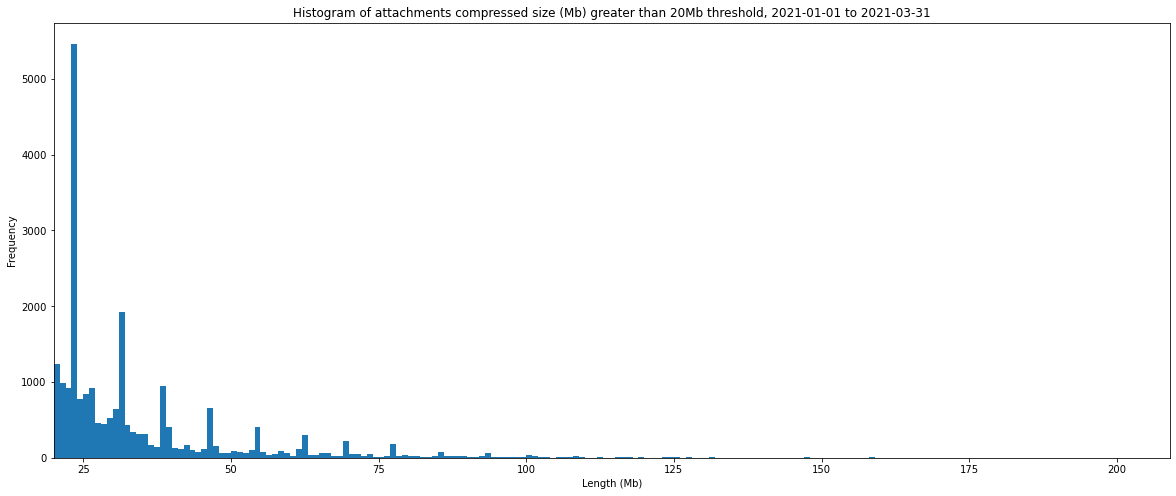

In [89]:
attachments_compressed_mb_greater_than_20_hist = attachments[compressed_greater_than_20]["compressed_size_mb"].plot.hist(title=f"Histogram of attachments compressed size (Mb) greater than 20Mb threshold, {start_date} to {end_date}", bins=range(200), figsize=(20,8))
attachments_compressed_mb_greater_than_20_hist.set_xlim(20)
attachments_compressed_mb_greater_than_20_hist.set(xlabel="Length (Mb)", ylabel="Frequency")
attachments_compressed_mb_greater_than_20_hist.ticklabel_format(style='plain', axis='y')

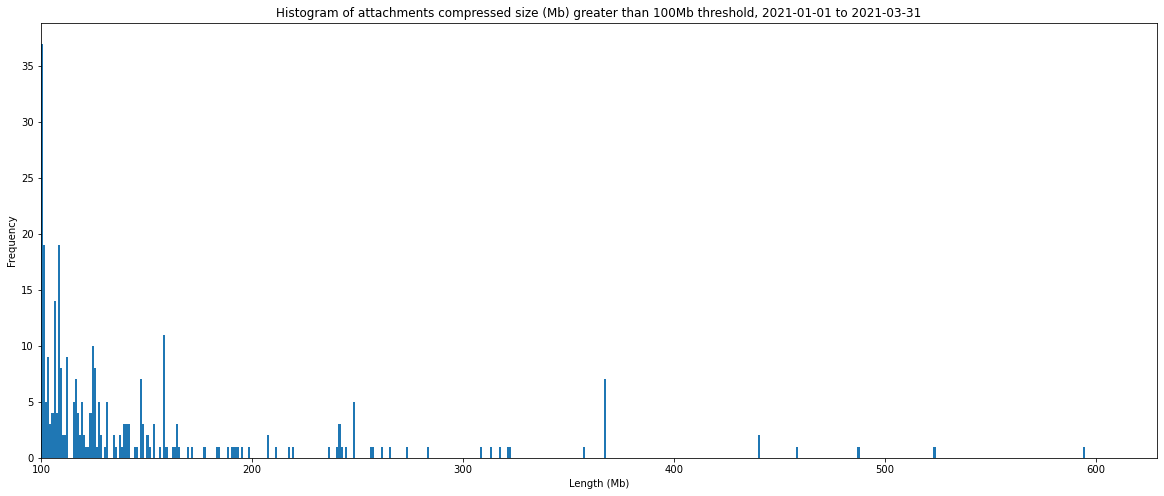

In [91]:
attachments_compressed_mb_greater_than_100_hist = attachments[compressed_greater_than_100]["compressed_size_mb"].plot.hist(title=f"Histogram of attachments compressed size (Mb) greater than 100Mb threshold, {start_date} to {end_date}", bins=range(600), figsize=(20,8))
attachments_compressed_mb_greater_than_100_hist.set_xlim(100)
attachments_compressed_mb_greater_than_100_hist.set(xlabel="Length (Mb)", ylabel="Frequency")
attachments_compressed_mb_greater_than_100_hist.ticklabel_format(style='plain', axis='y')

In [70]:
attachments[["compressed_size_mb", "content_type"]][compressed_greater_than_20].groupby("content_type").describe()

compressed_size_mb                                \
                                      count  mean   std   min   25%   50%   
content_type                                                                
application/msword                    37.00 29.95 11.69 20.05 21.95 24.87   
application/octet-stream              73.00 44.88 46.54 20.11 22.13 24.36   
application/pdf                     1118.00 50.65 61.38 20.00 23.96 31.16   
image/jpeg                             5.00 33.15 10.10 20.34 26.34 36.27   
image/png                            376.00 23.04  4.00 20.01 20.80 21.89   
image/tiff                         21411.00 34.25 17.30 20.00 23.34 27.91   
text/rtf                              13.00 25.93  5.37 21.19 22.40 23.56   

                                       
                           75%    max  
content_type                           
application/msword       30.44  70.75  
application/octet-stream 33.04 158.04  
application/pdf          47.74 676.58  
image/jpeg               36.27  46.51  
image/png                23.58  65.66  
image/tiff               38.77 357.14  
text/rtf                 27.95  38.48

In [71]:
attachments[["compressed_size_mb", "content_type"]][compressed_greater_than_100].groupby("content_type").describe()

compressed_size_mb                              \
                                      count   mean    std    min    25%   
content_type                                                              
application/octet-stream              11.00 152.90  17.06 101.46 158.04   
application/pdf                      106.00 198.35 115.04 100.55 125.26   
image/tiff                           188.00 122.01  38.07 100.02 101.54   

                                               
                            50%    75%    max  
content_type                                   
application/octet-stream 158.04 158.04 158.04  
application/pdf          147.31 242.04 676.58  
image/tiff               108.56 124.07 357.14

## Outcome of transfers with attachments 

In [72]:
from datetime import datetime
in_jan_feb = (attachments["time"] >= datetime(2021, 1, 1)) & (attachments["time"] < datetime(2021, 3, 1))

In [73]:
attachments_jan_feb = attachments[in_jan_feb]

In [140]:
print(f"Min time of dataset: {attachments_jan_feb['time'].min()}")
print(f"Max time of dataset: {attachments_jan_feb['time'].max()}")

Min time of dataset: 2021-01-01 06:12:24.691000
Max time of dataset: 2021-02-28 21:49:41.336000


In [141]:
print("Total attachments (jan/feb):", len(attachments_jan_feb))

Total attachments (jan/feb): 14850613


In [75]:
data_prefix = "s3://prm-gp2gp-data-sandbox-dev/transfers-sample-3/"
transfer_files = [
    "1-2021-transfers.parquet",
    "2-2021-transfers.parquet",
]
transfers_jan_feb = pd.concat((
    pd.read_parquet(data_prefix + f)
    for f in transfer_files
))

### GP2GP Error codes
- 11	Failed to integrate
- 14	Req not LM compliant
- 23	Sender not LM compliant	
- 29	LM reassembly
- 30	LM general failure	
- 31	Missing LM

In [76]:
client_failure_codes = [11,14,23,29,30,31]

In [77]:
def has_client_error(row):
    return \
        row["sender_error_code"] in client_failure_codes or \
        row["final_error_code"] in client_failure_codes or \
        any((e in client_failure_codes for e in row["intermediate_error_codes"]))

In [78]:
transfers_jan_feb["client_error"] = transfers_jan_feb.apply(has_client_error, axis=1)

In [79]:
has_client_error = transfers_jan_feb["client_error"]
transfers_jan_feb[has_client_error]["status"].value_counts()

PENDING_WITH_ERROR    5558
FAILED                1393
INTEGRATED             123
Name: status, dtype: int64

In [80]:
transfer_outcomes_jan_feb = transfers_jan_feb[["conversation_id", "status", "sender_error_code", "intermediate_error_codes", "final_error_code", "client_error"]].copy()

In [81]:
attachment_outcomes_jan_feb = attachments_jan_feb.merge(transfer_outcomes_jan_feb, on='conversation_id', how="left")

In [82]:
attachment_outcomes_jan_feb[["client_error", "compressed_size_mb"]].groupby("client_error").describe()

compressed_size_mb                                     
                          count mean  std  min  25%  50%  75%    max
client_error                                                        
False               14608485.00 0.25 1.44 0.00 0.01 0.03 0.09 594.00
True                  181814.00 0.89 6.06 0.00 0.01 0.04 0.13 523.18

In [83]:
jan_feb_compressed_greater_than_100 = attachment_outcomes_jan_feb["compressed_size_mb"] > 100
jan_feb_compressed_greater_than_20 = attachment_outcomes_jan_feb["compressed_size_mb"] > 20
jan_feb_compressed_greater_than_5 = attachment_outcomes_jan_feb["compressed_size_mb"] > 5
jan_feb_client_error = attachment_outcomes_jan_feb["client_error"]
jan_feb_any_failure = attachment_outcomes_jan_feb["status"] != "INTEGRATED"

In [84]:
attachment_outcomes_jan_feb["status"].value_counts(dropna=False)

INTEGRATED            13700914
FAILED                  800329
PENDING                 274439
NaN                      60206
PENDING_WITH_ERROR       14725
Name: status, dtype: int64

In [96]:
attachment_outcomes_jan_feb_compressed_greater_than_100 = attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_100]
attachment_outcomes_jan_feb_compressed_greater_than_20 = attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_20]
attachment_outcomes_jan_feb_compressed_greater_than_5 = attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_5]

In [95]:
print("Compressed greater than 100Mb - number of client errors")
attachment_outcomes_jan_feb_compressed_greater_than_100[["client_error", "compressed_size_mb"]].groupby("client_error").describe()

Compressed greater than 100Mb - number of client errors


compressed_size_mb                                           \
                          count   mean   std    min    25%    50%    75%   
client_error                                                               
False                    127.00 151.32 83.04 100.28 106.42 116.10 158.04   
True                      70.00 147.80 79.55 100.32 104.12 118.02 149.82   

                     
                max  
client_error         
False        594.00  
True         523.18

In [134]:
compressed_thresholds_jan_feb = pd.DataFrame({"compressed_threshold_mb": [5, 20, 100],
                                      "attachments_compressed_over_threshold": [jan_feb_compressed_greater_than_5, jan_feb_compressed_greater_than_20, jan_feb_compressed_greater_than_100]
                                     })

In [130]:
def count_attachments_over_threshold(row):
    return len(attachment_outcomes_jan_feb[row["attachments_compressed_over_threshold"]]);

def count_attachments_with_client_error(row):
    return len(attachment_outcomes_jan_feb[row["attachments_compressed_over_threshold"] & jan_feb_client_error])

def count_attachments_with_any_error(row):
    return len(attachment_outcomes_jan_feb[row["attachments_compressed_over_threshold"] & jan_feb_any_failure])

def calculate_attachments_with_client_error_percent(row):
    return f'{calculate_percentage(row["attachments_with_client_error"], row["attachments_over_threshold"])}%'

In [135]:
compressed_thresholds_jan_feb["attachments_over_threshold"] = compressed_thresholds_jan_feb.apply(count_attachments_over_threshold, axis=1)
compressed_thresholds_jan_feb["attachments_with_client_error"] = compressed_thresholds_jan_feb.apply(count_attachments_with_client_error, axis=1)
compressed_thresholds_jan_feb["attachments_with_any_error"] = compressed_thresholds_jan_feb.apply(count_attachments_with_any_error, axis=1)
compressed_thresholds_jan_feb["percent_attachments_with_client_error"] = compressed_thresholds_jan_feb.apply(calculate_attachments_with_client_error_percent, axis=1)

compressed_thresholds_jan_feb[["compressed_threshold_mb", "attachments_over_threshold", "attachments_with_any_error", "attachments_with_client_error", "percent_attachments_with_client_error"]].set_index("compressed_threshold_mb")

,attachments_over_threshold,attachments_with_any_error,attachments_with_client_error,percent_attachments_with_client_error
compressed_threshold_mb,,,,
5,119879,15039,5957,4.96918%
20,13902,2735,1695,12.19249%
100,201,76,70,34.82587%


In [86]:
# attachments_over_100mb_count = len(attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_100])
# attachments_over_100mb_with_client_error_count = len(attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_100 & jan_feb_client_error])
# attachments_over_100mb_with_any_error_count = len(attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_100 & jan_feb_any_failure])

# print("Total attachments (jan/feb):", len(attachment_outcomes_jan_feb))
# print("Attachments over 100mb (jan/feb):", attachments_over_100mb_count)
# print("Attachments over 100mb that had a client error (jan/feb):", attachments_over_100mb_with_client_error_count)
# print("Attachments over 100mb that had any failure (jan/feb):", attachments_over_100mb_with_any_error_count)

# print(attachments_over_100mb_with_client_error_count / attachments_over_100mb_count * 100)

Total attachments (jan/feb): 14850613
Attachments over 100mb (jan/feb): 201
Attachments over 100mb that had a client error (jan/feb): 70
Attachments over 100mb that had any failure (jan/feb): 76
34.82587064676617


In [87]:
# attachments_over_20mb_count = len(attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_20])
# attachments_over_20mb_with_client_error_count = len(attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_20 & jan_feb_client_error])
# attachments_over_20mb_with_any_error_count = len(attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_20 & jan_feb_any_failure])

# print("Total attachments (jan/feb):", len(attachment_outcomes_jan_feb))
# print("Attachments over 20mb (jan/feb):", attachments_over_20mb_count)
# print("Attachments over 20mb that had a client error (jan/feb):", attachments_over_20mb_with_client_error_count)
# print("Attachments over 20mb that had any failure (jan/feb):", attachments_over_20mb_with_any_error_count)

# print(attachments_over_20mb_with_client_error_count / attachments_over_20mb_count * 100)

Total attachments (jan/feb): 14850613
Attachments over 20mb (jan/feb): 13902
Attachments over 20mb that had a client error (jan/feb): 1695
Attachments over 20mb that had any failure (jan/feb): 2735
12.192490289167027


In [88]:
# attachments_over_5mb_count = len(attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_5])
# attachments_over_5mb_with_client_error_count = len(attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_5 & jan_feb_client_error])
# attachments_over_5mb_with_any_error_count = len(attachment_outcomes_jan_feb[jan_feb_compressed_greater_than_5 & jan_feb_any_failure])

# print("Total attachments (jan/feb):", len(attachment_outcomes_jan_feb))
# print("Attachments over 5mb (jan/feb):", attachments_over_5mb_count)
# print("Attachments over 5mb that had a client error (jan/feb):", attachments_over_5mb_with_client_error_count)
# print("Attachments over 5mb that had any failure (jan/feb):", attachments_over_5mb_with_any_error_count)

# print(attachments_over_5mb_with_client_error_count / attachments_over_5mb_count * 100)

Total attachments (jan/feb): 14850613
Attachments over 5mb (jan/feb): 119879
Attachments over 5mb that had a client error (jan/feb): 5957
Attachments over 5mb that had any failure (jan/feb): 15039
4.969177253730845
